### Deep Learning Supervised Text Classification
- BiLSTM (baseline data augmentation, i.e., standard methods)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime


### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2209031206', # line strike
    '2210031122'  # site compliance or practice issue
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at twenty-two m depth se...,0
2,robodrill spider excavator being operated when...,1
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


## Prepare Base Data (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 107 [17, 82, 343, 355, 514, 534, 1559, 1750, 1960, 1965, 2117, 2142, 2380, 2447, 2482, 2701, 2867, 3526, 3619, 3672, 3759, 3803, 3880, 3908, 3989, 4047, 4118, 4355, 4374, 4421, 4890, 5244, 5444, 6371, 6584, 6585, 6831, 6935, 7814, 7969, 8551, 8704, 8794, 9041, 9153, 9201, 9381, 9556, 9596, 9659, 9815, 9826, 9829, 11286, 11403, 11658, 11684, 11779, 12091, 12196, 12517, 12669, 12830, 12882, 13467, 13652, 13715, 15027, 16050, 18773, 20094, 20272, 20446, 21302, 21344, 21919, 22531, 22578, 22835, 22993, 23279, 23358, 24007, 24075, 24310, 26148, 26401, 26864, 29258, 30436, 30716, 35411, 50966, 51336, 55157, 57713, 61714, 64840, 69153, 70741, 76577, 77778, 78574, 79345, 81714, 82479, 88394]
Train: 470 [2, 24, 46, 143, 151, 235, 237, 241, 273, 404, 443, 454, 490, 518, 548, 751, 813, 897, 994, 1024, 1188, 1296, 1373, 1399, 1401, 1418, 1461, 1513, 1531, 1537, 1546, 1556, 1558, 1587, 1678, 1684, 1704, 1754, 1774, 1812, 1857, 1883, 2041, 2043, 2066, 2075, 2120, 2123, 2124, 2131, 2199, 2215, 

In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues

,text,category
2,robodrill spider excavator being operated when...,1
24,fuel red diesel spilled onto whiterockdirt sur...,1
46,oil leak from crane that was on site for plann...,1
143,small oil spill on twenty-one thousand and twe...,1
151,spider excavator hyd leak to soil 10ml spider ...,1
...,...,...
90259,struck by discharged object or substance an em...,1
90458,injured by slipping or swinging object held by...,1
90618,struck by swinging part of powered vehicle an ...,1
91361,caught in running equipment or machinery durin...,1


## Augment Data using Basic Data Augmentation (BDA)

In [ ]:
# Load fabricated reports
fn_name = 'hydraulic fluid or oil leak_4700_simple_da'
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
df_fab

,text,category
0,robodrill spider excavator being operated when...,1
1,robodrill spider excavator being operated when...,1
2,robodrill spider excavator being operated when...,1
3,robodrill spider excavator being operated hyd ...,1
4,robodrill excavator being when hose fitting fa...,1
...,...,...
4695,against object or equipment unspecified an emp...,1
4696,struck against object or equipment unspecified...,1
4697,struck against object or unspecified an employ...,1
4698,struck against object well kept or equipment u...,1


In [ ]:
# Prepare data & conbine with original training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

# Complete the new training dataframe
df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery nec a...,0
4,caught in running equipment or machinery durin...,0
...,...,...
79780,against object or equipment unspecified an emp...,1
79781,struck against object or equipment unspecified...,1
79782,struck against object or unspecified an employ...,1
79783,struck against object well kept or equipment u...,1


In [ ]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,homeworking ip tested positive for covid19 ip ...,0
1,direct exposure to electricity greater than tw...,0
2,struck by discharged object or substance an em...,0
3,pedestrian struck by vehicle in nonroadway are...,0
4,fall on same level due to slipping an employee...,0
...,...,...
79780,theft of generator third incident trespasser e...,0
79781,caught in running equipment or machinery unspe...,0
79782,employees reported gunshots being fired from o...,0
79783,compressed or pinched by shifting objects or e...,0


In [ ]:
# Visually check a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
37268,hydraulic rollers in the workshop began to lea...,1
7307,was hose leak from excavator three thousand fo...,1
13860,security officers car motor parking area the c...,1
53611,spill to grade twenty liters from t crane cran...,1
7414,minor hydraulic inunct spill incidental on fou...,1
25413,during commissioning process hpu actuator oil ...,1
30165,ignition of vapors gases or liquids on august ...,1
26235,struck by get around or slipping object other ...,1
2898,ml of hydraulic fluid went to grade from grade...,1
27447,contact with hot objects or substances an empl...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 69944
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3497250   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

26401    a skid steer hydraulic hose broke causing no m...
12669    hydraulic oil from a burst excavator hose has ...
13652    hydraulic hose burst during quarry works a hyd...
514      faulty hydraulic hose hydraulic hose failed re...
82       minor spill to grade one liter from cat front ...
                               ...                        
51336    struck by discharged object or substance an em...
15027    release of preservation oil during inspection ...
4047     hb1117 hydraulic fitting leak on starboard cra...
355      hydraulic hose failure on a 360excavator resul...
76577    contact with hot objects or substances a linem...
Name: text, Length: 107, dtype: object

In [ ]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 4653
Number of positives in validation data: 517


In [ ]:
# Train the model
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=3,
                              batch_size=128,
                              verbose=1)

Epoch 1/3
561/561 [==============================] - 1914s 3s/step - loss: 0.0786 - categorical_accuracy: 0.9408 - val_loss: 0.0240 - val_categorical_accuracy: 0.9388
Epoch 2/3
561/561 [==============================] - 1906s 3s/step - loss: 0.0273 - categorical_accuracy: 0.9317 - val_loss: 0.0227 - val_categorical_accuracy: 0.9307
Epoch 3/3
561/561 [==============================] - 1927s 3s/step - loss: 0.0153 - categorical_accuracy: 0.9340 - val_loss: 0.0123 - val_categorical_accuracy: 0.9341


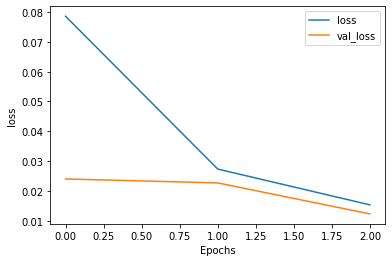

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18665
           1       0.65      0.88      0.75       107

    accuracy                           1.00     18772
   macro avg       0.83      0.94      0.87     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

,text,pred,rule_book
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
8937,hydraulic oil spilt to ground approx two l due to hydraulic hose failure on scraper thirteen operator of scraper thirteen notice a spray mist of hydraulic oil coming from articulation area of the scraper whilst operating in stage three lot seven scraper was shut downspill response initiated,1,0
14421,rear dump tractor trailer tipped during offloading while in the process of offloading classfive aggregate to reinforce the crane stands a rear dump tractor trailer was approximately fifty elevated in preparation to dump his load when the driver claims that he felt the right rear of his trailer give way the driver attempted to dump his load but was tipped on its side before he could finish the trailer broke away from the truck as designed and the truck remained in place the hydraulic cylinder did release approximately four gallons of hydraulic oil that was contained and remediated work stopped and assessed for any injuries spill contained and remediated using spill kit soils were overexcavated and placed in an overpack drum,1,0
20986,excavator operated on a frozen slope slid sideways a short distance an excavator operator had to cross over a swale in the east gorge area of the pgwmf to assist with the moving of a water discharge hose as the unit climbed a slope on the east side of swale climbing on an angle to the slope the unti slid sideways downslope as the ground was frozen and traction was lost the operator attempted to use the bucket to stop the slide but it would not hold on the frozen ground when manipulating the bucket the hose to be moved was struck causing a small break and nonimpacted water was released nonreportable spill created and reported separately by environmental monitoring team the work was stopped and the contractor after evaluating the situation was able to get the excavator out of the swale,1,0
270,diesel leak from wood dump truck caused by broken hose clamp on tuesday january twenty-eight two thousand and twenty at seven hundred and fifteen hours wood employees contacted wood superintendent concerning a diesel fuel leak approximately five gallons on a wood dump truck caused by a broken hose clamp connecting the fuel hose to the fuel tank the leak began on zapata street in freeport and continued as the dump truck entered dow through gate twenty-four and was observed when the dump truck stopped on levee road at median street dow hsse was contacted and responded to above intersection dow hsse assessed the leak to be under five gallons of fuel wood employees cleaned up fuel leakage by scraping two inches of ground using a front end loader and depositing contaminated spoil in drums for disposal spill was located on both asphalt and dirt roadways leak stopped supervision and dow hsse notified extent of leak determined cleanup conducted per client protocol,1,0
36,enm nacap 8t excavator experienced hyd hose what happened 0930hrsenvironmental near miss enm when a hydraulic hose of an 8t cat excavator split during rehabilitation operations at kp 45the release of hydraulic oil was contained within and on the machine spill kits were located on siteall contaminated materials absorbent pads were disposed of appropriately into the contaminated waste bags,1,0
76655,caught in running equipment or machinery during regular operation two employees were operating the slitter machine and hydraulic table on line one employee one was operating the controls while employee two was using a wooden stick to pick up the ends of sheet metal coming from the 


There are 50 entries (out of 107)...

Total no. of positive predictions is  144...

Total no. of positive hits is  94...


In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

,text,pred,rule_book
2867,operator was performing excavations for new pump separator foundations in the process of performing such task operator struck a four fiberglass line with backhoe rear bucket causing damage to line incident 36335morning meeting took place bjsa were put in place crews broke off and bjsa were further reviewed individually and thoroughly by crews stop work authority was covered hazards were identified mitigations were reviewed along with last minute risk assessments and assurance of one call being in place backhoe operator and spotter proceeded to perform task previously reviewed in meetingbjsa which was excavating foundations for a new production separator hydrovac had been performed on all lines in immediate area all lines were exposed and all had a good view of all lines excavations was nearly complete and operator was performing some sloping as a final step on one of the excavations for easy accessegress this excavation was twenty-six x26 x26 deep spotter and 2nd crew member alerted operator to stop work as he was too close to the four fiberglass line line was on east side of excavation operator failed to stop excavation task spotter and 2nd crew member continued insisting and used swa but again operator failed to stop excavation task seconds later operator struck the low pressure four fiberglass line with backhoe rear bucket causing damage to line wateroil mixture was released from line low pressure line does not have constant fluids running through it this minimized the release oxy operations was notified they then shut the line in immediately line was repaired and completed by end of shift see detailed description,0,1
11403,whilst carrying out piling activity a hydraulic hose connection failed causing hyraulic oil to spray on to the adjacent building on the morning of monday 30th april at approx one thousand the hose fitting on to the upper 22m in height gearbox of the piling rig failed this caused a spray of fluid 3040ltrs to spray out to a distance of up to 60m and make contact with the neighbouring buildings exterior steel claddingit was very windy with lots of raindue to the wet weather it was not noticed until the following day the extent of the spread of fluid unfortunately the subcontractor did not notify the site management team about the incident due to them not knowing about the oil release breakdown was reported once informed the following day the afw site team reported it to the pc who airlined the incidentdawson wam stopped work carried out the required repair and checked the remaining fittings for further signs of leaks none were identifiedthe first stage of cleaning the neighbouring buildings cladding within the construction area has already begun with an assessment taking place for any other cleaning requirements outside of the construction area,0,1
534,"damaged plate compactor was discovered on the north side of the hill dividing construction and plant properties safety department was contacted to investigate a damaged plate compactor on the north side of the hill dividing plant and construction properties the compactor was apparently damaged by a metal tracked piece of mobile equipment judging by the damage and markings the damage caused the compactor fuel and oil to spill onto the ground the total amount not exceeding three gallons this incident appears to have ocurred within the previous two days judging by ground conditions and tracks in the area but was not discovered andor reported until twelve million, one hundred and eighty-two thousand and nineteen the damaged equipment was removed from the area and placed in a containment the contaminated soil was excavated and placed in a fifty-five gallon drum for proper disposal an investigation was launched and all civil operators and spotters were interviewed no employees were aware of the damaged equipment and all reported last seeing it in good condition the evening of twelve million, one hundred and sixty-two thousand and nineteen


There are 13 entries (out of 107)...


In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus}_bilstm_bda_model.pkl'
pickle.dump(model, open(filename, 'wb'))